# MANUAL TESTING

In [6]:
import os 

os.chdir('../')

# Load Sandbox

In [7]:
from app.core.sandbox import Sandbox
from pathlib import Path

box = Sandbox(Path('TEMP_TEST_DIR'), 'Opos-test.xlsx')



In [8]:
SHEET_STATE = box.get_sheet_state()

In [9]:
SHEET_STATE

'Sheet "Sheet1" has 151 rows (Including the header row) and 22 columns (A(1): "Zuordnung" (<class \'str\'>), B(2): "Buchungsdatum" (<class \'datetime.datetime\'>), C(3): "Belegart" (<class \'str\'>), D(4): "Belegnummer" (<class \'str\'>), E(5): "Belegdatum" (<class \'datetime.datetime\'>), F(6): "Geschäftsbereich" (<class \'NoneType\'>), G(7): "Position" (<class \'str\'>), H(8): "Buchungsschlüssel" (<class \'str\'>), I(9): "Negativbuchung" (<class \'NoneType\'>), J(10): "Mahnstufe" (<class \'str\'>), K(11): "Zahlweg" (<class \'NoneType\'>), L(12): "Skontobasis" (<class \'float\'>), M(13): "Zahlungsfr.basis" (<class \'datetime.datetime\'>), N(14): "Tage 1" (<class \'float\'>), O(15): "Skontosatz 1" (<class \'float\'>), P(16): "Nettofälligkeit" (<class \'datetime.datetime\'>), Q(17): "Sonderhauptb.Kennz." (<class \'NoneType\'>), R(18): "Betrag in Belegwährung" (<class \'float\'>), S(19): "Währung" (<class \'str\'>), T(20): "Betrag in Hauswährung" (<class \'float\'>), U(21): "Währung" (<c

# Test Runnables

In [6]:
from app.graph.chains import GraphRunnables
from app.api.endpoints.opos import *

runnables = GraphRunnables()


In [ ]:
# Test Decomposer 
decomp_results = runnables.decomposer_chain.invoke({"instruction": INSTRUCTION_PROMPT,
                                                    "sheet_state": SHEET_STATE})

subtasks = decomp_results.subtasks
subtasks

['Standardize and validate the due date column (P “Nettofälligkeit”) on “Sheet1”: ensure every entry is a datetime object interpreted as German format (DD.MM.YYYY) and flag any parsing errors.',
 'Scan rows 2–151 on “Sheet1” and identify cumulative rows by flagging any row where: the “Belegnummer” (D) is empty or non-numeric, or “Belegdatum” (E), “Nettofälligkeit” (P), or “Betrag in Belegwährung” (R) is empty, or any cell in the row contains the terms “debitor”, “debtor”, or “creditor” (case-insensitive). Collect their Excel row numbers.',
 'From “Sheet1” rows not flagged as cumulative, select those with “Betrag in Belegwährung” (R) > 0 and collect their Excel row numbers as the invoice rows list.',
 'From “Sheet1” rows not flagged as cumulative, select those with “Betrag in Belegwährung” (R) < 0 and collect their Excel row numbers as the credit rows list.',
 'For each row in the invoice rows list and each row in the credit rows list, verify that the following columns are non-empty: D 

In [ ]:
# Test actor 
actor_results = runnables.actor_chain.invoke({"subtasks": subtasks,
                                              "failed_code": "",
                                              "errors_or_issues": ""
                                              })
actor_results.tool_calls[0]['args']['code_snippet']

'from datetime import datetime\n\n# Access the main sheet\nsheet1 = workbook[\'Sheet1\']\n\n# Subtask 1: Standardize and validate due dates in column P (16)\ndue_dates = {}              # row -> datetime\ndue_date_errors = []        # rows with parsing errors\nfor row in range(2, sheet1.max_row + 1):\n    cell = sheet1.cell(row, 16)\n    val = cell.value\n    if isinstance(val, datetime):\n        due_dates[row] = val\n    elif isinstance(val, str):\n        try:\n            dt = datetime.strptime(val, \'%d.%m.%Y\')\n            cell.value = dt\n            due_dates[row] = dt\n        except Exception:\n            due_date_errors.append(row)\n    else:\n        due_date_errors.append(row)\n\n# Subtask 2: Identify cumulative rows (rows 2–151)\nterms = (\'debitor\', \'debtor\', \'creditor\')\ncumulative_rows = []\nfor row in range(2, 152):\n    d = sheet1.cell(row, 4).value\n    e = sheet1.cell(row, 5).value\n    p = sheet1.cell(row, 16).value\n    r = sheet1.cell(row, 18).value\n    

In [16]:
# Run the code in the sandbox
prev_state = SHEET_STATE
box.step(actor_results.tool_calls[0]['args']['code_snippet'])
if len(box.stderr) == 0 :
    print("No errors in execution")
else:
    print("Errors in execution:")
    print(box.stderr)
current_state = box.get_sheet_state()
code_snippet = actor_results.tool_calls[0]['args']['code_snippet']

In [18]:
# Test Reflector
from app.graph.chains import GraphRunnables


runnables = GraphRunnables()

 
reflector_results = runnables.reflector_chain.invoke({"code_snippet": code_snippet,
                                                            "previous_sheet_state": prev_state,
                                                            "current_sheet_state":current_state,
                                                            "subtasks": subtasks})

reflector_results

ReflectorVerdict(is_solved=True, issues=None)

## Visualize Graph

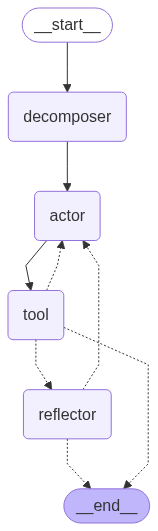

In [12]:
# Visualize Graph
from IPython.display import Image, display
from app.graph.graph import SheetAgentGraph

Agent = SheetAgentGraph(None, None)
graph = Agent.build_graph()
diagram = graph.get_graph().draw_mermaid_png()

# Save and Display Graph
graph.get_graph().draw_mermaid_png(output_file_path="sheet_agent_workflow.png")
display(Image(diagram))


In [3]:
import openpyxl
workbook = openpyxl.load_workbook("../Opos-test.xlsx")

In [4]:
from datetime import datetime

# Access Sheet1
sheet1 = workbook['Sheet1']

# Map headers to column indices
header_row = sheet1[1]
header_to_col = {cell.value: cell.col_idx for cell in header_row}

# Identify key columns
col_belegnum = header_to_col.get('Belegnummer')
col_belegdatum = header_to_col.get('Belegdatum')
col_nettofaellig = header_to_col.get('Nettofälligkeit')
col_amount = header_to_col.get('Betrag in Belegwährung')
# Find debtor/creditor name, address, number columns by header keywords
name_cols = [idx for hdr, idx in header_to_col.items() if hdr and 'name' in hdr.lower()]
addr_cols = [idx for hdr, idx in header_to_col.items() if hdr and 'adresse' in hdr.lower()]
num_cols = [idx for hdr, idx in header_to_col.items() if hdr and 'nummer' in hdr.lower() and hdr != 'Belegnummer']

# Step 1: Parse German format dates if needed
for row in sheet1.iter_rows(min_row=2, max_row=151):
    # Check and parse Belegdatum
    cell_bd = row[col_belegdatum - 1]
    if isinstance(cell_bd.value, str):
        try:
            cell_bd.value = datetime.strptime(cell_bd.value.strip(), '%d.%m.%Y')
        except:
            pass
    # Check and parse Nettofälligkeit
    cell_nf = row[col_nettofaellig - 1]
    if isinstance(cell_nf.value, str):
        try:
            cell_nf.value = datetime.strptime(cell_nf.value.strip(), '%d.%m.%Y')
        except:
            pass

# Prepare classification and collections
daily_target = datetime(2025, 7, 26)
classifications = {}
invoice_rows = []
credit_rows = []
cumulative_rows = []
invoice_completeness = {}
credit_completeness = {}
invoice_maturity = {}
credit_maturity = {}

# Classify rows and compute basics
for row in sheet1.iter_rows(min_row=2, max_row=151):
    rnum = row[0].row
    beleg = row[col_belegnum - 1].value
    dat = row[col_belegdatum - 1].value
    nf = row[col_nettofaellig - 1].value
    amt = row[col_amount - 1].value
    # Check missing or keywords
    missing = any(val is None or (isinstance(val, str) and not val.strip()) for val in [beleg, dat, nf, amt])
    lowered = ' '.join(str(val).lower() for val in [beleg, dat, nf])
    keyword = any(k in lowered for k in ['debitor', 'debtor', 'creditor'])
    if missing or keyword:
        cls = 'cumulative'
        cumulative_rows.append(rnum)
    else:
        try:
            amt_val = float(amt)
        except:
            amt_val = 0
        if amt_val >= 0:
            cls = 'invoice'
            invoice_rows.append(rnum)
        else:
            cls = 'credit'
            credit_rows.append(rnum)
    classifications[rnum] = cls

# Completeness checks
def check_completeness(rnum):
    row = sheet1[rnum]
    vals = []
    # mandatory fields
    vals.append(row[col_belegnum].value)
    vals.append(row[col_amount].value)
    for c in name_cols + addr_cols + num_cols:
        vals.append(row[c - 1].value)
    return all(v is not None and (not isinstance(v, str) or v.strip()) for v in vals)

for r in invoice_rows:
    invoice_completeness[r] = check_completeness(r)
for r in credit_rows:
    credit_completeness[r] = check_completeness(r)

# Sums
Invoice_Sum = sum(float(sheet1[r][col_amount - 1].value) for r in invoice_rows)
Credit_Sum = sum(float(sheet1[r][col_amount - 1].value) for r in credit_rows)

# Maturities
for r in invoice_rows:
    nf = sheet1[r][col_nettofaellig - 1].value
    invoice_maturity[r] = (daily_target - nf).days
for r in credit_rows:
    nf = sheet1[r][col_nettofaellig - 1].value
    credit_maturity[r] = (daily_target - nf).days

# Buckets definition
def bucket_key(days):
    if days < 0:
        return '<0'
    elif days <= 30:
        return '1-30'
    elif days <= 60:
        return '31-60'
    else:
        return '>60'

# Invoice ageing
invoice_buckets = {b: {'total': 0} for b in ['<0', '1-30', '31-60', '>60']}
for r, days in invoice_maturity.items():
    b = bucket_key(days)
    invoice_buckets[b]['total'] += float(sheet1[r][col_amount - 1].value)
for b, vals in invoice_buckets.items():
    vals['pct'] = (vals['total'] / Invoice_Sum * 100) if Invoice_Sum else 0

# Credit ageing
credit_buckets = {b: {'total': 0} for b in ['<0', '1-30', '31-60', '>60']}
for r, days in credit_maturity.items():
    b = bucket_key(days)
    credit_buckets[b]['total'] += float(sheet1[r][col_amount - 1].value)
for b, vals in credit_buckets.items():
    vals['pct'] = (vals['total'] / Credit_Sum * 100) if Credit_Sum else 0

# Top 10 credits (most negative)
credit_sorted = sorted(credit_rows, key=lambda r: float(sheet1[r][col_amount - 1].value))
top_10_credits = [(r,
                  sheet1[r][col_belegnum - 1].value,
                  float(sheet1[r][col_amount - 1].value)) for r in credit_sorted[:10]]
# Top 10 invoices (highest)
invoice_sorted = sorted(invoice_rows, key=lambda r: float(sheet1[r][col_amount - 1].value), reverse=True)
top_10_invoices = [(r,
                   sheet1[r][col_belegnum - 1].value,
                   float(sheet1[r][col_amount - 1].value)) for r in invoice_sorted[:10]]

# Duplicate invoice numbers
i_num_counts = {}
for r in invoice_rows:
    num = sheet1[r][col_belegnum - 1].value
    i_num_counts[num] = i_num_counts.get(num, 0) + 1
duplicate_invoice_numbers = [num for num, cnt in i_num_counts.items() if cnt > 1]

# Duplicate debtor identifiers or names in cumulative
deb_ids = []
deb_names = []
for r in cumulative_rows:
    for c in num_cols:
        deb_ids.append(sheet1[r][c - 1].value)
    for c in name_cols:
        deb_names.append(sheet1[r][c - 1].value)

dup_deb_ids = [v for v, cnt in __import__('collections').Counter(deb_ids).items() if cnt > 1]
dup_deb_names = [v for v, cnt in __import__('collections').Counter(deb_names).items() if cnt > 1]

# Create Analysis sheet
if 'Analysis' in workbook.sheetnames:
    del workbook['Analysis']
analysis = workbook.create_sheet('Analysis')
col = 1
# 1. Cumulative Row Numbers
analysis.cell(1, col).value = 'Cumulative Row Numbers'
for idx, val in enumerate(cumulative_rows, start=2):
    analysis.cell(idx, col).value = val
col += 2
# 2. Invoice Row Numbers
analysis.cell(1, col).value = 'Invoice Row Numbers'
for idx, val in enumerate(invoice_rows, start=2):
    analysis.cell(idx, col).value = val
col += 2
# 3. Credit Row Numbers
analysis.cell(1, col).value = 'Credit Row Numbers'
for idx, val in enumerate(credit_rows, start=2):
    analysis.cell(idx, col).value = val
col += 2
# 4. Completeness table
analysis.cell(1, col).value = 'Invoice_Completeness'
analysis.cell(1, col+1).value = 'Credit_Completeness'
max_rows = max(len(invoice_rows), len(credit_rows))
for i in range(max_rows):
    if i < len(invoice_rows):
        r = invoice_rows[i]
        analysis.cell(2+i, col).value = invoice_completeness[r]
    if i < len(credit_rows):
        r = credit_rows[i]
        analysis.cell(2+i, col+1).value = credit_completeness[r]
col += 3
# 5. Invoice_Sum and Credit_Sum
analysis.cell(1, col).value = 'Invoice_Sum'
analysis.cell(2, col).value = Invoice_Sum
col += 2
analysis.cell(1, col).value = 'Credit_Sum'
analysis.cell(2, col).value = Credit_Sum
col += 2
# 6. Invoice ageing report
analysis.cell(1, col).value = 'Bucket'
analysis.cell(1, col+1).value = 'Total'
analysis.cell(1, col+2).value = 'Percentage'
for i, b in enumerate(invoice_buckets.keys(), start=2):
    analysis.cell(i, col).value = b
    analysis.cell(i, col+1).value = invoice_buckets[b]['total']
    analysis.cell(i, col+2).value = invoice_buckets[b]['pct']
col += 4
# 7. Credit ageing report
analysis.cell(1, col).value = 'Bucket'
analysis.cell(1, col+1).value = 'Total'
analysis.cell(1, col+2).value = 'Percentage'
for i, b in enumerate(credit_buckets.keys(), start=2):
    analysis.cell(i, col).value = b
    analysis.cell(i, col+1).value = credit_buckets[b]['total']
    analysis.cell(i, col+2).value = credit_buckets[b]['pct']
col += 4
# 8. Top 10 credit positions
analysis.cell(1, col).value = 'Row'
analysis.cell(1, col+1).value = 'Belegnummer'
analysis.cell(1, col+2).value = 'Amount'
for i, (r, num, amt) in enumerate(top_10_credits, start=2):
    analysis.cell(i, col).value = r
    analysis.cell(i, col+1).value = num
    analysis.cell(i, col+2).value = amt
col += 4
# 9. Top 10 invoice positions
analysis.cell(1, col).value = 'Row'
analysis.cell(1, col+1).value = 'Belegnummer'
analysis.cell(1, col+2).value = 'Amount'
for i, (r, num, amt) in enumerate(top_10_invoices, start=2):
    analysis.cell(i, col).value = r
    analysis.cell(i, col+1).value = num
    analysis.cell(i, col+2).value = amt
col += 4
# 10. Duplicate invoice numbers
analysis.cell(1, col).value = 'Duplicate Invoice Numbers'
for i, val in enumerate(duplicate_invoice_numbers, start=2):
    analysis.cell(i, col).value = val
col += 2
# 11. Duplicate debtor identifiers or names
analysis.cell(1, col).value = 'Duplicate Debtor Identifiers or Names'
for i, val in enumerate(dup_deb_ids + dup_deb_names, start=2):
    analysis.cell(i, col).value = val


In [5]:
workbook.save("../69Opos-test69.xlsx")